# Mirae Asset Portfolio Optimization

## Objective Overview
- This project focuses on optimizing the Mirae Asset portfolio.
- The goal is to leverage the LSTM (Long Short-Term Memory) model to optimize the investment allocation for each stock.
- The provided stock data includes daily opening, high, low, closing prices, trading volume, and issued shares.
- The objective is to determine the optimal investment weights for each stock, aiming for an effective portfolio composition.

- 본 프로젝트는 미래에셋 포트폴리오의 최적화에 중점을 둡니다.
- 목표는 LSTM(Long Short-Term Memory) 모델을 활용하여 각 주식에 대한 투자 할당을 최적화하는 것입니다.
- 제공된 주식 데이터에는 일별 시가, 고가, 저가, 종가, 거래량, 발행된 주식수 등이 포함됩니다.
- 각 주식에 대한 최적의 투자 비중을 결정하여 효과적인 포트폴리오 구성을 목표로 합니다.

In [1]:
# Standard library imports
from datetime import datetime
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
import torch
import torch.nn as nn

# Local application imports
import module

# Suppress warnings
warnings.filterwarnings("ignore")

/var/folders/2b/n21s51zs701f5bnpdk36200m0000gn/T/ipykernel_9883/3256091736.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 1. Loading Data From CSV 
1. Raw Data
2. Treasury Yield(Monthly)
3. Treasury Yield(Daily)

In [2]:

# Load your data
raw_stock = pd.read_csv('data/raw_data_ts.csv')
monthly_treasury_bond =   pd.read_csv('data/TB3MS.csv')
daily_treasury_bond = pd.read_csv('data/TB3MS_daily.csv')



# 2. Cleaning Data & Calculating Log Returns

In [3]:


# Define a function to parse the date with a custom pivot year
def parse_date(date_str):
    date = datetime.strptime(date_str, '%m/%d/%y')
    if date.year > 2023:
        date = date.replace(year=date.year - 100)
    return date

# Load the data
raw_stock = pd.read_csv('data/raw_data_ts.csv')

# Convert the 'eval_d' column to datetime
raw_stock['eval_d'] = raw_stock['eval_d'].apply(parse_date)

# Set the 'eval_d' column as the index
raw_stock.set_index('eval_d', inplace=True)

# Define the tickers
tickers = raw_stock['code_'].unique()

# Define the start and end dates
start_date = parse_date('1/03/18') 
end_date = parse_date('12/31/23')  

# Check if end_date exists in the DataFrame's index
if end_date not in raw_stock.index:
    end_date = raw_stock.index.max()

# Initialize an empty DataFrame to store the log returns
log_returns_df = pd.DataFrame()

# Calculate the log returns for each ticker
for ticker in tickers:
    # Filter the data for the given ticker
    data = raw_stock[raw_stock['code_'] == ticker]['close_']
    
    # Filter the data for the date range
    data = data.loc[start_date:end_date]
    
    # Check if the data is empty
    if data.empty:
        print(f"No data for ticker {ticker} from {start_date} to {end_date}")
        continue
    
    # Calculate the log returns
    log_returns = np.log(data / data.shift(1))
    
    # Drop NaN values
    log_returns = log_returns.dropna()
    
    # Add the log returns to the DataFrame
    log_returns_df[ticker] = log_returns



 ## 3. Calculate Lognormal Returns For Each Available S002 - S514

1. Additivity: Log returns are additive over time, making cumulative return calculations straightforward.

2. Normal Distribution Approximation: Lognormal returns are closer to a normal distribution, enhancing the applicability of certain statistical analyses.

3. Continuous Compounding: Log returns are related to continuously compounded returns, providing a more realistic assumption.

4. Stability in Extreme Values: Log returns are more stable when dealing with extreme values or outliers.

 

Source: https://arxiv.org/abs/2202.03858


*Missing Values such as eval_d were dropped/filtered dynamically

## 로그 수익률(Log Returns) 사용 이유

주식 투자에서 로그 수익률을 사용하는 이유에 대해 설명하겠습니다.

### 1. 로그 수익률의 정의

로그 수익률은 현재 가격과 이전 가격 간의 로그 차이를 계산한 값입니다. 수학적으로, 주식 가격 P의 로그 수익률은 다음과 같이 정의됩니다:

\[ \text{로그 수익률} = \log\left(\frac{P_t}{P_{t-1}}\right) \]

### 2. 정확성

로그 수익률은 간단한 수익률(단순히 현재 가격에서 이전 가격을 빼는 방식)에 비해 정확한 결과를 제공합니다. 로그 변환은 수학적으로 미분 가능하며, 주식 수익률의 정규 분포 가정에 더 부합합니다.

### 3. 로그 수익률의 이점

- **변환의 선형성:** 로그 수익률은 덧셈 대신 곱셈으로 변환되어 계산되므로, 시간 간격의 합산이 간편해집니다.
- **정규 분포 가정:** 로그 수익률은 종종 정규 분포에 가까워져 통계적 분석이 더 용이해집니다.

로그 수익률은 주식 시계열 데이터를 다루는 데 더 적합하며, 정확한 분석과 포트폴리오 최적화를 위해 일반적으로 선호됩니다.

## 방법론
1. **데이터 선택:**
   - 데이터셋은 open, high, low, close 가격, 거래량 및 기타 관련 세부 정보를 포함한 주식 관련 정보로 구성되어 있습니다.
   - 이 분석에서는 'code_' 열에서 식별된 다양한 주식 범주를 특별히 고려합니다.

2. **기간:**
   - 분석은 '2018-01-03'부터 '2023-12-29'까지의 기간을 다루며, 이는 다년간의 주식 성과에 대한 시각을 제공합니다.

3. **평균 로그 수익률 계산:**
   - 각 고유 주식 범주 ('code_')에 대해 스크립트는 일일 종가를 기반으로 로그 수익률을 계산합니다.
   - 로그 수익률은 연속된 종가의 비율의 자연 로그로 계산됩니다.

4. **결과 해석:**
   - 출력 데이터프레임 ('avg_log_returns_df')은 각 주식 범주의 평균 로그 수익률을 포착합니다.
   - '평균 로그 수익률' 열은 특정 기간 동안 각 주식 범주의 평균 로그 비율 변화에 대한 통찰을 제공합니다.


### Daily Log Returns for the 2018/1/03 - 2023/12/31 Year Period 

In [4]:
log_returns_df

,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
eval_d,,,,,,,,,,,,,,,,,,,,,
2018-01-04,0.004466,0.013002,-0.004606,-0.018509,0.017748,0.008763,0.009803,0.011970,-0.004223,0.004634,...,0.001383,0.003237,0.009028,0.011771,0.012854,-0.001843,0.000333,-0.008325,0.003711,-0.005719
2018-01-05,0.016033,0.004627,0.013755,0.006953,0.012879,0.012322,0.006001,0.011504,0.005941,0.011321,...,-0.000807,-0.002284,-0.006440,0.008215,0.020518,0.013579,0.005908,0.006210,0.023667,0.017258
2018-01-08,0.014322,-0.006948,0.010318,0.000000,0.000609,0.001020,0.010467,-0.001620,-0.000277,-0.003721,...,0.004486,-0.001716,0.001476,0.007960,0.001445,0.007624,0.002390,0.060755,0.004030,-0.016152
2018-01-09,0.004665,0.004968,-0.006279,-0.025352,0.003890,-0.000680,0.001632,0.008931,0.015276,-0.000115,...,-0.004255,-0.015000,0.005056,0.003329,0.001443,-0.002180,-0.013943,-0.008118,-0.001929,0.007510
2018-01-10,0.001300,0.009208,0.005528,-0.026012,-0.008162,-0.004544,-0.005314,0.002194,-0.002840,-0.000229,...,-0.007984,0.001549,0.010944,-0.003518,0.002255,-0.000160,-0.021343,0.003321,-0.001092,-0.005502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.002734,0.006904,0.007816,0.019353,0.004948,0.002780,0.003207,-0.002319,0.017144,-0.005563,...,0.001768,0.001602,-0.000597,0.016212,0.001557,-0.001979,-0.004722,-0.007731,-0.004286,0.015283
2023-12-26,-0.000065,0.012781,0.003786,0.050772,0.001249,0.000214,-0.000094,-0.000819,-0.000915,-0.002845,...,0.002254,-0.000267,0.005897,-0.002882,-0.001014,0.004067,0.008794,0.015988,0.002821,-0.002067
2023-12-27,-0.000456,-0.000591,0.003177,0.005135,0.006810,-0.001576,-0.002357,-0.003651,0.009221,0.000518,...,-0.004711,-0.004546,0.005980,0.001103,0.001627,0.008419,-0.005066,0.018647,-0.000888,0.001680


# Average log returns between that period

In [5]:
avg_log_returns = log_returns_df.mean() * 252  # Multiply by 252 to annualize the average daily return

total_log_returns = log_returns_df.sum()

avg_log_returns



S002    0.154786
S005    0.020417
S009    0.042550
S012    0.017489
S013    0.228738
S017    0.246028
S019    0.132589
S021    0.199414
S026    0.078290
S027    0.250447
S043    0.043470
S059    0.157158
S084    0.144605
S087    0.373317
S089    0.061251
S092    0.080517
S095    0.131340
S130    0.207735
S131    0.154588
S143    0.166150
S146    0.024918
S154    0.143286
S171    0.153168
S184    0.090590
S186    0.018219
S188    0.075649
S193   -0.040638
S196    0.425830
S206    0.013661
S232   -0.036449
S240    0.104502
S292    0.151185
S321    0.101373
S335    0.321689
S344    0.110981
S354    0.089742
S356   -0.037409
S393    0.077042
S404    0.160274
S425   -0.022275
S439    0.023832
S445   -0.055152
S457    0.075868
S469    0.137122
S482    0.170539
S489    0.108795
S493    0.237380
S498    0.411983
S505    0.135692
S514    0.073336
dtype: float64

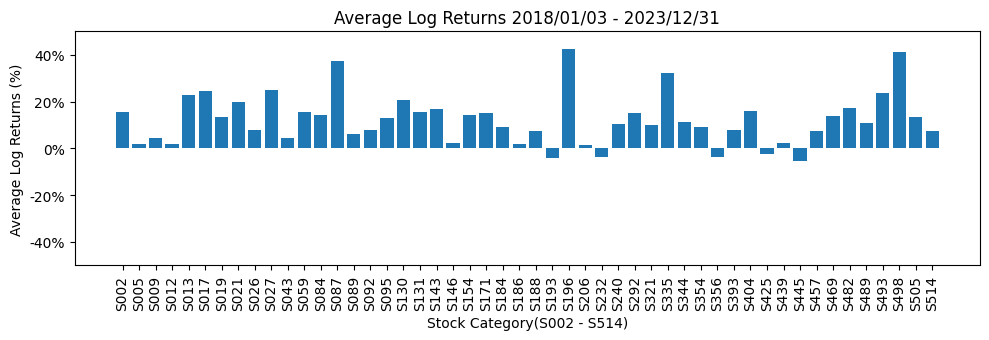

In [6]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the average 5-year log returns
plt.subplot(2, 1, 1)  # Create a subplot in the top half of the figure
plt.bar(avg_log_returns.index, avg_log_returns * 100)  # Multiply by 100 to convert to percentage
plt.title('Average Log Returns 2018/01/03 - 2023/12/31')
plt.xlabel('Stock Category(S002 - S514)')
plt.ylabel('Average Log Returns (%)')  # Indicate that the log returns are in percentage form
plt.xticks(rotation=90)

# Set y-axis range from -100% to 100%
plt.ylim(-50, 50)

# Format y-axis as percentage
fmt = '%.0f%%'  # Format you want the ticks, e.g. '0%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# Adjust the layout to prevent overlap between subplots
plt.tight_layout()

# Display the plot
plt.show()



## 4. Portfolio Optimization and Significance of Covariance Matrix


### 1. Risk Measurement and Diversification:
   - The covariance matrix is instrumental in quantifying the relationships between different assets in a portfolio.
   - Positive covariances suggest assets that tend to move together, while negative covariances indicate assets with potentially opposing movements.
   - Diversification, a key strategy in risk management, relies on the covariance matrix to identify assets that exhibit low or negative covariances. By combining such assets, investors can effectively reduce overall portfolio risk.



### 2. Efficient Frontier and Sharpe Ratio:
   - The covariance matrix is integral to the concept of the Efficient Frontier, which represents the set of optimal portfolios that offer the highest expected return for a defined level of risk.
   - Metrics like the Sharpe Ratio, a measure of risk-adjusted returns, utilize the covariance matrix to assess the performance of portfolios. A higher Sharpe Ratio indicates better risk-adjusted returns.

### 3. Significance of Covariance Matrix in Optimization Models:
   - Optimization models aiming to find the optimal weights for assets within a portfolio require a precise covariance matrix.
   - The covariance matrix provides critical input for algorithms and mathematical models that seek to maximize the Sharpe Ratio or achieve other portfolio optimization objectives.

## 공분산 행렬의 중요성


### 1. 리스크 측정과 다양화:
   - 공분산 행렬: 포트폴리오 내 자산 간 관계 양적 측정
   - 양/음의 공분산: 자산 간 움직임 패턴 파악
다양화: 낮거나 음의 공분산 자산 결합, 전체 리스크 감소
### 2. 효율적인 투자선과 샤프 비율:

   - 공분산 행렬: 효율적인 투자선에 중요한 역할
   - 샤프 비율: 리스크 조정 수익평가에 활용
### 3. 최적화 모델에서 공분산 행렬의 중요성:

   - 최적화 모델: 정확한 공분산 행렬 필수
   - 공분산 행렬: 최적화 알고리즘과 모델 입력으로 중요


In [7]:
# Calculate the covariance matrix
cov_matrix = log_returns_df.cov()

print("Covariance matrix:")
# cov_matrix
cov_matrix

Covariance matrix:


,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
S002,0.000497,0.000159,0.000178,0.000243,0.000319,0.000296,0.000169,0.000339,0.000110,0.000278,...,0.000090,0.000052,0.000133,0.000206,0.000223,0.000368,0.000257,0.000380,0.000190,0.000085
S005,0.000159,0.000463,0.000204,0.000232,0.000225,0.000190,0.000187,0.000182,0.000131,0.000197,...,0.000268,0.000106,0.000375,0.000216,0.000248,0.000200,0.000236,0.000255,0.000227,0.000135
S009,0.000178,0.000204,0.000315,0.000226,0.000215,0.000205,0.000179,0.000218,0.000129,0.000207,...,0.000149,0.000082,0.000176,0.000190,0.000203,0.000191,0.000229,0.000202,0.000181,0.000125
S012,0.000243,0.000232,0.000226,0.000579,0.000292,0.000270,0.000201,0.000291,0.000149,0.000268,...,0.000177,0.000089,0.000210,0.000217,0.000240,0.000296,0.000324,0.000342,0.000210,0.000144
S013,0.000319,0.000225,0.000215,0.000292,0.000504,0.000321,0.000213,0.000380,0.000144,0.000294,...,0.000138,0.000074,0.000198,0.000272,0.000298,0.000347,0.000305,0.000399,0.000258,0.000132
S017,0.000296,0.000190,0.000205,0.000270,0.000321,0.000361,0.000205,0.000345,0.000135,0.000285,...,0.000119,0.000071,0.000171,0.000233,0.000251,0.000314,0.000277,0.000344,0.000222,0.000124
S019,0.000169,0.000187,0.000179,0.000201,0.000213,0.000205,0.000353,0.000226,0.000111,0.000190,...,0.000119,0.000076,0.000171,0.000182,0.000187,0.000189,0.000199,0.000183,0.000167,0.000100
S021,0.000339,0.000182,0.000218,0.000291,0.000380,0.000345,0.000226,0.000536,0.000143,0.000309,...,0.000111,0.000055,0.000166,0.000255,0.000276,0.000368,0.000317,0.000410,0.000250,0.000125
S026,0.000110,0.000131,0.000129,0.000149,0.000144,0.000135,0.000111,0.000143,0.000248,0.000131,...,0.000089,0.000074,0.000114,0.000119,0.000123,0.000119,0.000131,0.000124,0.000117,0.000132
S027,0.000278,0.000197,0.000207,0.000268,0.000294,0.000285,0.000190,0.000309,0.000131,0.000399,...,0.000137,0.000069,0.000178,0.000218,0.000248,0.000310,0.000290,0.000378,0.000218,0.000112


# Establish Risk Free Rate 

- Risk-Free Rate as a Baseline:

The risk-free rate serves as a baseline return that an investor could achieve with zero risk. It represents the return on an investment that is considered to have no credit risk, as it is backed by the government (in this case, U.S. Treasury bills).

- 베이스로서의 리스크 프리 금리:
리스크 프리 금리는 투자자가 제로 리스크로 달성할 수 있는 기준 수익을 나타냅니다. 이는 정부(이 경우 미국 국채)에 의해 보증된 신용 리스크가 없는 투자의 수익을 대표합니다.

## 5. Verifying Data 
This code performs a correlation check between daily and monthly risk-free rates. It converts date columns to datetime format, filters data for the specified date range, and calculates average risk-free rates. The script prints the average monthly and daily risk-free rates. To verify correctness, it merges daily and monthly datasets on the date column and calculates the correlation between the 'TB3MS' (monthly) and 'value_' (daily) columns, providing insights into the relationship between daily and monthly risk-free rates. The correlation result indicates the degree of linear relationship between the two sets of data, assessing their similarity or divergence.

일일 및 월별 무위험 금리 간의 상관 관계를 확인합니다. 날짜 열을 datetime 형식으로 변환하고 지정된 날짜 범위에 대한 데이터를 필터링하며 평균 무위험 금리를 계산합니다. 스크립트는 평균 월간 및 일일 무위험 금리를 출력합니다. 정확성을 확인하기 위해 날짜 열을 기준으로 일일 및 월간 데이터를 병합하고 'TB3MS'(월간) 및 'value_'(일일) 열 간의 상관 관계를 계산합니다. 상관 관계 결과는 일일과 월간 무위험 금리 간의 선형 관계의 정도를 나타내며 두 데이터 세트 간의 유사성 또는 차이를 평가합니다

In [8]:


# Convert 'eval_d' to datetime
daily_treasury_bond['eval_d'] = pd.to_datetime(daily_treasury_bond['eval_d'], format='%m/%d/%y')

# Filter the daily data for the same date range
filtered_daily_data = daily_treasury_bond.loc[(daily_treasury_bond['eval_d'] >= start_date) & (daily_treasury_bond['eval_d'] <= end_date)]

# Calculate the average daily risk-free rate
average_daily_risk_free_rate = filtered_daily_data['value_'].mean()

# Convert 'eval_d' to datetime in monthly_treasury_bond
monthly_treasury_bond['eval_d'] = pd.to_datetime(monthly_treasury_bond['eval_d'], format='%m/%d/%y')

# Filter the data
filtered_data = monthly_treasury_bond.loc[(monthly_treasury_bond['eval_d'] >= start_date) & (monthly_treasury_bond['eval_d'] <= end_date)]

# Calculate the average risk-free rate
average_risk_free_rate = filtered_data['TB3MS'].mean()

# Print the average risk-free rate
print(f"Average monthly risk-free rate: {average_risk_free_rate}")

# Print the average daily risk-free rate
print(f"Average daily risk-free rate: {average_daily_risk_free_rate}")

# To test the correctness, you can compare the average daily and monthly risk-free rates
# To calculate the correlation between the daily and monthly data, you first need to merge the two datasets on the 'eval_d' column
merged_data = pd.merge(filtered_data, filtered_daily_data, on='eval_d', how='inner')

# Then, you can calculate the correlation between the 'TB3MS' and 'value_' columns
correlation = merged_data['TB3MS'].corr(merged_data['value_'])

# Print the correlation
print(f"Correlation between daily and monthly risk-free rates: {correlation}")

Average monthly risk-free rate: 1.9236619718309862
Average daily risk-free rate: 1.8581618655692729
Correlation between daily and monthly risk-free rates: 0.988888198639779


## 평균 무위험 이자율 (월간):
## 값: 1.9237%

의미: 5년 동안의 월 평균 무위험 이자율을 나타냅니다. 투자자가 무위험 투자에서 기대할 수 있는 이익으로, 이 기간 동안 약 1.9237%입니다.

## 평균 일일 무위험 이자율:
## 값: 1.8613%

의미: 동일한 5년 기간 동안의 일일 국채 데이터에서 계산된 평균 일일 무위험 이자율입니다. 월 평균 이자율보다 약간 낮은 수치로, 일일 이자율은 짧은 기간 동안의 시장 상황에 민감하게 반응할 수 있다는 것을 나타냅니다.

## 일일과 월간 무위험 이자율 간의 상관 관계:
## 값: 0.9889

의미: 높은 상관 관계(0.9889)는 일일과 월간 무위험 이자율 간에 강한 양의 관련성이 있다는 것을 나타냅니다. 다시 말해, 일일 및 월간 이율이 밀접하게 함께 움직입니다. 높은 상관 관계는 일일 이자율의 변화가 월간 이자율의 변화와 매우 일관되게 발생한다는 것을 나타냅니다.

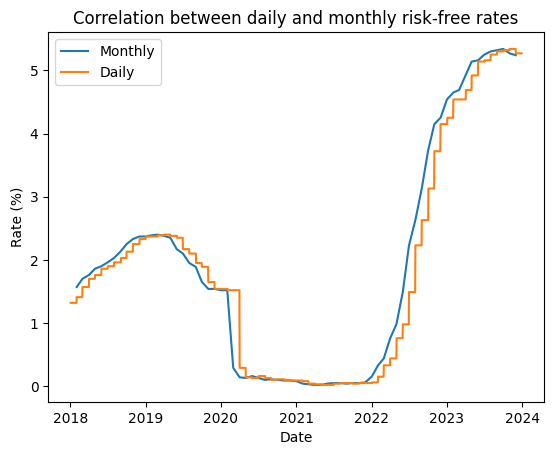

In [9]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the average monthly risk-free rate
ax.plot(filtered_data['eval_d'], filtered_data['TB3MS'], label='Monthly')

# Plot the average daily risk-free rate
ax.plot(filtered_daily_data['eval_d'], filtered_daily_data['value_'], label='Daily')

# Set the title and labels
ax.set_title('Correlation between daily and monthly risk-free rates')
ax.set_xlabel('Date')
ax.set_ylabel('Rate (%)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

## 6. 동일 가중치 포트폴리오 분석

이 분석에서는 동일 가중치 포트폴리오가 비교를 위한 기준으로 고려됩니다. 이 포트폴리오에 대한 주요 지표가 계산됩니다:

1. **포트폴리오 가중치:**
   - 포트폴리오는 각 주식이 동일하게 가중되어 분배되는 동일 가중치 구조를 가집니다.

2. **무위험 이자율:**
   - 무위험 이자율은 1.86%로 설정되어 있으며, 이는 제로 리스크를 갖는 투자의 기준 수익률을 나타냅니다.

3. **지표 계산:**
   - **표준 편차:** 포트폴리오 변동성을 나타내는 지표.
   - **기대 수익률:** 역사적 로그 수익률을 기반으로 예상되는 수익률.
   - **샤프 비율:** 리스크 대비 조정된 지표로, 리스크 당 수익을 나타냅니다.

4. **결과:**
   - 표준 편차, 기대 수익률 및 샤프 비율은 동일 가중치 포트폴리오의 성능에 대한 통찰력을 제공하며, 이는 추가적인 최적화를 위한 기준으로 작용합니다.

##  Equal Weight Portfolio Analysis

In this analysis, an equal-weight portfolio is considered as a baseline for comparison. Key metrics are calculated for this portfolio:

1. **Portfolio Weights:**
   - The portfolio is equally weighted, meaning each stock receives an equal allocation.

2. **Risk-Free Rate:**
   - The risk-free rate is set at 1.86%, representing a baseline return with zero risk.

3. **Metrics Calculation:**
   - **Standard Deviation:** A measure of portfolio volatility.
   - **Expected Return:** The anticipated return based on historical log returns.
   - **Sharpe Ratio:** A risk-adjusted measure, indicating return per unit of risk.

4. **Results:**
   - Standard Deviation, Expected Return, and Sharpe Ratio provide insights into the performance of the equal-weight portfolio, serving as a baseline for further optimization.


In [10]:

weights = np.array([1/len(tickers)] * len(tickers))

# Define the risk-free rate
risk_free_rate = 0.0186

# Define the functions to calculate the standard deviation, expected return, and Sharpe ratio
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

std_dev = standard_deviation(weights, cov_matrix)
exp_return = expected_return(weights, log_returns_df)
sharpe = sharpe_ratio(weights, log_returns_df, cov_matrix, risk_free_rate)


print(f"Standard Deviation: {std_dev}")
print(f"Expected Return: {exp_return}")
print(f"Sharpe Ratio: {sharpe}")


Standard Deviation: 0.01322430475371814
Expected Return: 0.12271231725381615
Sharpe Ratio: 7.872800815826932


# Current Equal-Weighted Portfolio Result

## Key Metrics
- **Standard Deviation (Risk):** 0.0132
  - Indicates relatively low volatility, suitable for risk-averse investors.
- **Expected Return:** 0.1227 (Annualized)
  - Suggests potential for attractive returns.
- **Sharpe Ratio:** 7.8728
  - Reflects strong risk-adjusted performance.


The current equal-weighted portfolio demonstrates a well-optimized structure with a favorable balance between risk and return. It is appealing to investors seeking lower volatility, attractive returns, and strong risk-adjusted performance. Consideration should be given to individual risk tolerance and financial goals when evaluating this portfolio.

# 현재 동일 가중치 포트폴리오 결과

## 주요 지표
- **표준 편차 (리스크):** 0.0132
  - 비교적 낮은 변동성으로, 리스크 회피형 투자자에게 적합합니다.
- **기대 수익률:** 0.1227 (연간화)
  - 매력적인 수익 가능성을 시사합니다.
- **샤프 비율:** 7.8728
  - 강한 리스크 조정 성과를 나타냅니다.


현재 동일 가중치 포트폴리오는 리스크와 수익 간에 유리한 균형을 보이며 최적화된 구조를 나타냅니다. 변동성이 낮고 수익이 높으며 강력한 리스크 조정 성과를 추구하는 투자자에게 매력적입니다. 이 포트폴리오를 평가할 때 개별 리스크 허용 수준과 재무 목표를 고려해야 합니다.



## 7. 포트폴리오 최적화: 효율적 투자선

개별 포트폴리오의 리스크와 수익 지표를 평가한 후, 다음 단계는 효율적 투자선을 탐색하는 것입니다. 이는 주어진 리스크 수준에서 기대 수익률이 최대가 되거나 주어진 기대 수익률에서 리스크가 최소가 되는 최적의 포트폴리오 집합입니다. 코드는 각 주식에 무작위 가중치를 할당하여 다수의 무작위 포트폴리오를 생성하고 각각의 수익, 변동성 및 샤프 비율을 계산합니다.

### 주요 구성 요소:

- **num_portfolios:** 생성된 무작위 포트폴리오의 수.
- **all_weights:** 각 포트폴리오의 각 주식 가중치를 저장하는 배열.
- **ret_arr, vol_arr, sharpe_arr:** 각 포트폴리오의 계산된 수익, 변동성 및 샤프 비율을 저장하는 배열.

루프는 지정된 포트폴리오 수에 대해 무작위 가중치를 생성하고 해당하는 수익, 변동성 및 샤프 비율을 계산합니다. 결과 데이터는 리스크와 수익의 트레이드 오프를 시각화하기 위해 산점도로 표시됩니다.

### 시각화:

- **산점도:** 각 점은 무작위 포트폴리오를 나타냅니다. X 축은 변동성, Y 축은 수익을 나타내며 색상은 샤프 비율에 매핑됩니다.
- **빨간 점:** 초기 포트폴리오의 리스크와 수익을 나타냅니다.

이것은 효율적인 투자선을 구성하는 포트폴리오를 식별하는 데 도움이되며, 리스크와 수익 간의 최적의 균형을 제공합니다. 색상 그라데이션은 샤프 비율을 나타내어 우수한 리스크 조정 수익을 제공하는 포트폴리오를 선택하는 데 도움이됩니다. 빨간 점은 초기 포트폴리오의 리스크와 수익을 표시합니다.

## Portfolio Optimization: Efficient Frontier

Following risk and return analysis, the focus shifts to the Efficient Frontier—an assortment of optimal portfolios maximizing expected return for a given risk or minimizing risk for a desired return. The code generates random portfolios with assigned weights to each stock, calculating returns, volatilities, and Sharpe ratios.

### Key Components:

- **num_portfolios:** Number of generated random portfolios.
- **all_weights:** Array storing stock weights for each portfolio.
- **ret_arr, vol_arr, sharpe_arr:** Arrays logging returns, volatilities, and Sharpe ratios for each portfolio.

The loop generates random weights, computes corresponding returns, volatilities, and Sharpe ratios for the specified number of portfolios. Visualization entails a scatter plot with x-axis denoting volatility, y-axis representing return, and color mapped to the Sharpe ratio.

### Visualization:

- **Scatter Plot:** Each point signifies a random portfolio. X-axis denotes volatility, y-axis represents return, and color signifies Sharpe ratio.
- **Red Dot:** Marks the risk and return of the original portfolio.

This aids in identifying Efficient Frontier portfolios, providing insights into the optimal risk-return balance. Color gradient reflects Sharpe ratio, aiding selection of portfolios with superior risk-adjusted returns. The red dot marks risk and return of the initial portfolio.

---




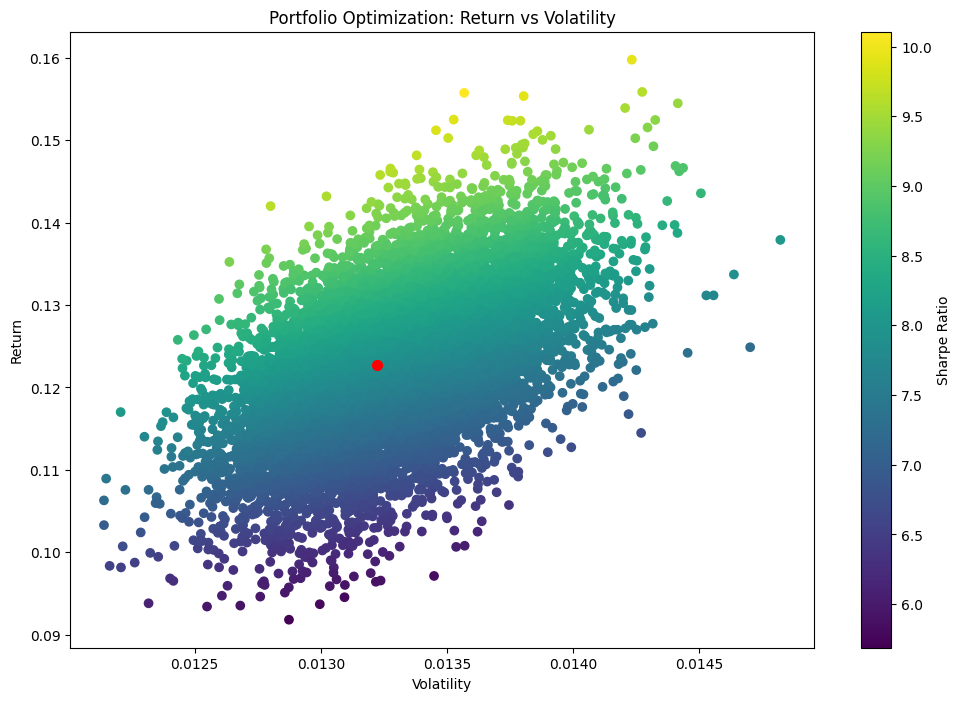

In [11]:

num_portfolios = 10000
all_weights = np.zeros((num_portfolios, len(tickers)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for x in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights

    # Expected return
    ret_arr[x] = expected_return(weights, log_returns_df)

    # Expected volatility
    vol_arr[x] = standard_deviation(weights, cov_matrix)

    # Sharpe Ratio
    sharpe_arr[x] = sharpe_ratio(weights, log_returns_df, cov_matrix, risk_free_rate)

# Plotting the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(std_dev, exp_return,c='red', s=50) # red dot
plt.title('Portfolio Optimization: Return vs Volatility')
plt.show()

# 8. LSTM Model 

Utilizing LSTM in portfolio optimization exploits its proficiency in capturing sequential patterns, crucial for financial time series dynamics. The model, a specialized Recurrent Neural Network (RNN), adeptly navigates the temporal dependencies and intricate interactions among assets. This code applies an LSTM model to predict future log returns, leveraging its memory cells to encode and utilize past information effectively. The architecture aligns with financial market dynamics, making LSTM a robust choice for enhanced portfolio optimization.

LSTM은 순차적인 패턴을 포착하는 데 뛰어난 능력을 발휘하여 포트폴리오 최적화에 활용됩니다. 해당 모델은 전문화된 순환 신경망(RNN)으로, 자산 간의 시간적 의존성과 복잡한 상호 작용을 효과적으로 탐색합니다. 이 코드는 LSTM 모델을 활용하여 미래 로그 수익을 예측하며, 메모리 셀을 활용하여 과거 정보를 효과적으로 인코딩합니다. 이 아키텍처는 금융 시장의 동적인 특성과 일치하여 LSTM을 향상된 포트폴리오 최적화에 강력한 선택으로 만듭니다.

훈련 데이터 (70%): LSTM 모델을 훈련하는 데 사용되며, 모델이 데이터의 일반적인 패턴 및 동향을 학습할 수 있도록 충분한 양의 데이터가 필요합니다.

검증 데이터 (15%): 모델의 성능을 평가하고 하이퍼파라미터 튜닝을 위한 검증 단계에 사용됩니다. 검증 데이터는 훈련 동안 모델이 이전에 본 적이 없는 데이터에 대한 성능을 평가하는 데 중요합니다.

테스트 데이터 (15%): 최종 모델의 일반화 성능을 평가하기 위한 용도로 사용됩니다. 모델이 새로운 데이터에서 얼마나 잘 수행되는지 확인하는 데 사용됩니다.

In [12]:
train_data = log_returns_df.loc[:'2021-06-30']
valid_data = log_returns_df.loc['2021-07-01':'2022-06-30']
test_data = log_returns_df.loc['2022-07-01':]


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
valid_data_scaled = scaler.transform(valid_data)
test_data_scaled = scaler.transform(test_data)

# Convert scaled data to tensors
train_data_scaled = torch.tensor(train_data_scaled).float()
valid_data_scaled = torch.tensor(valid_data_scaled).float()
test_data_scaled = torch.tensor(test_data_scaled).float()

In [14]:


train_seq = torch.tensor(train_data_scaled[:-1], dtype=torch.float)
train_label = torch.tensor(train_data_scaled[1:], dtype=torch.float)

valid_seq = torch.tensor(valid_data_scaled[:-1], dtype=torch.float)
valid_label = torch.tensor(valid_data_scaled[1:], dtype=torch.float)

test_seq = torch.tensor(test_data_scaled[:-1], dtype=torch.float)
test_label = torch.tensor(test_data_scaled[1:], dtype=torch.float)


# 포트폴리오 최적화를 위한 LSTM 모델

## 데이터 분할:
- 로그 수익률 데이터는 특정 날짜 범위를 기반으로 훈련, 검증 및 테스트 세트로 분할됩니다.

## 정규화:
- 로그 수익률 데이터는 Min-Max 스케일링을 사용하여 정규화됩니다. 이렇게 하면 데이터가 0에서 1의 범위로 변환되어 신경망에 일관된 입력이 제공됩니다.

## 시퀀스 생성:
- 로그 수익률의 시퀀스가 생성되며 각 시퀀스는 과거 로그 수익률의 창을 나타냅니다. 이러한 시퀀스는 LSTM 모델을 훈련하기 위한 입력 기능으로 사용됩니다.

## LSTM 모델 아키텍처:
- LSTM 모델 아키텍처는 두 개의 레이어로 정의되어 있으며 각각 256개의 메모리 셀을 포함합니다. 각 LSTM 레이어 뒤에는 과적합을 방지하기 위해 드롭아웃 레이어가 추가됩니다. 출력 레이어는 입력 기능과 동일한 차원을 가진 밀도 레이어입니다.

## 모델 컴파일:
- 모델은 회귀 문제에 적합한 평균 제곱 오차 손실 함수 및 Adam 옵티마이저를 사용하여 컴파일됩니다. Adam 옵티마이저는 훈련 중에 학습률을 조절합니다.

## 콜백:
- 조기 종료 및 모델 체크포인트 콜백이 정의됩니다. 조기 종료는 검증 손실을 모니터링하고 향상이 멈추면 훈련을 중단합니다. 모델 체크포인팅은 검증 손실을 기준으로 최상의 모델을 저장합니다.

## 모델 훈련:
- LSTM 모델은 훈련 세트의 로그 수익률 시퀀스를 사용하여 훈련됩니다. 훈련은 효율적인 계산을 위해 여러 epoch 동안 배치 크기 32로 수행됩니다.

이러한 단계는 LSTM 모델을 구축하고 훈련시켜 미래 로그 수익률을 예측하는 데 활용됩니다. LSTM은 금융 시계열 역동성의 순차적 패턴을 효과적으로 포착하는 데 능숙하여 이를 활용합니다.


In [15]:


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)
test_scaled = scaler.transform(test_data)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : (i + seq_length)]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10  # Adjust as needed
X_train = create_sequences(train_scaled, seq_length)
y_train = train_scaled[seq_length:]

X_valid = create_sequences(valid_scaled, seq_length)
y_valid = valid_scaled[seq_length:]

X_test = create_sequences(test_scaled, seq_length)
y_test = test_scaled[seq_length:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(X_train.shape[2]))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/100
28/28 [==============================] - 2s 28ms/step - loss: 0.0613 - val_loss: 0.0076
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0213 - val_loss: 0.0083
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0079
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0146 - val_loss: 0.0067
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0130 - val_loss: 0.0097
Epoch 6/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0129 - val_loss: 0.0069
Epoch 7/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0118 - val_loss: 0.0067
Epoch 8/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0118 - val_loss: 0.0081
Epoch 9/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 10/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0104 - val_loss: 0.0075

### 훈련된 LSTM 모델을 활용한 예측

#### 예측 수행:
- 훈련된 LSTM 모델을 사용하여 테스트 세트(`X_test`)에 대한 예측이 수행됩니다.

#### 스케일 변환 뒤집기:
- 모델에서 얻은 예측된 로그 수익률은 스케일러를 사용하여 원래 척도로 변환됩니다.

#### 슬라이싱 조정:
- 예측된 로그 수익률의 모양과 일치하도록 테스트 데이터가 슬라이싱됩니다.

#### 로그 수익률 비율 계산:
- 로그 수익률 비율은 예측된 로그 수익률과 해당 테스트 데이터 하위 집합 간의 백분율 차이로 계산됩니다.

#### 시그모이드 함수 적용 및 정규화:
- 비율은 시그모이드 함수를 사용하여 처리되고 [0, 1] 범위로 정규화됩니다.

#### DataFrame 인덱스 및 열 설정:
- 결과로 얻은 DataFrame(`log_returns_ratio`)는 테스트 데이터와 일치하는 인덱스와 열이 할당됩니다.

#### 사용:
- `log_returns_ratio` DataFrame은 필요에 따라 출력하거나 활용할 수 있습니다.

In [16]:
# Make predictions using the trained LSTM model on the test set
test_predictions = model.predict(X_test)

# Invert the scaling to get the predicted log returns
predicted_log_returns = scaler.inverse_transform(test_predictions)

# Adjust the slicing of test_data to match the shape of predicted_log_returns
test_data_subset = test_data.iloc[-predicted_log_returns.shape[0]:].values

# Calculate the ratio for log returns
log_returns_ratio = (pd.DataFrame(predicted_log_returns) - test_data_subset) / test_data_subset

# Apply a sigmoid function and normalize the ratio to the range [0, 1]
log_returns_ratio = 1 / (1 + np.exp(-log_returns_ratio))
log_returns_ratio = (log_returns_ratio - log_returns_ratio.min(axis=0)) / (log_returns_ratio.max(axis=0) - log_returns_ratio.min(axis=0))

# Set the index and columns of the ratio DataFrame
log_returns_ratio.index = test_data.index[-predicted_log_returns.shape[0]:]
log_returns_ratio.columns = test_data.columns

# Print or use the log_returns_ratio DataFrame as needed
log_returns_ratio

12/12 [==============================] - 0s 5ms/step


,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
eval_d,,,,,,,,,,,,,,,,,,,,,
2022-07-18,0.145317,0.000076,0.340143,0.078158,0.263254,0.322051,0.242064,0.318199,0.236545,0.286252,...,0.235175,0.274115,0.268849,0.313085,0.376628,0.368222,0.401816,0.321248,0.296149,0.280163
2022-07-19,0.208347,0.262551,0.309271,0.252423,0.267410,0.259528,0.284107,0.291629,0.228185,0.270889,...,0.253585,0.284258,0.254009,0.309068,0.261560,0.399121,0.258067,0.295465,0.275298,0.302873
2022-07-20,0.204200,0.000103,0.207594,0.197009,0.260477,0.228129,0.319924,0.283214,0.284953,0.252895,...,0.216115,0.271077,0.980401,0.297259,0.136250,0.387404,0.151792,0.283741,0.489647,0.288790
2022-07-21,0.203988,0.226835,0.294934,0.044178,0.262885,0.235538,0.280961,0.282655,0.253785,0.259836,...,0.300478,0.269437,0.240588,0.307269,0.249762,0.202186,0.218951,0.272564,0.264837,0.057139
2022-07-22,0.211402,0.339873,0.392453,0.272075,0.519555,0.292126,0.330597,0.305245,0.084865,0.301879,...,0.347245,0.269365,0.273407,0.000000,0.310773,0.398249,0.341513,0.373513,0.291625,0.232469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.207281,0.226617,0.295720,0.242842,0.298955,0.180955,0.400062,0.333582,0.224225,0.298171,...,0.086762,0.282765,0.168951,0.308654,0.123223,0.391679,0.392114,0.224688,0.303780,0.265165
2023-12-26,0.615910,0.242633,0.268300,0.251254,0.394884,0.000145,0.000000,0.488314,0.322788,0.341520,...,0.107142,0.238088,0.251414,0.303038,0.658634,0.382824,0.210598,0.289046,0.223078,0.332186
2023-12-27,0.252858,0.879322,0.261110,0.203529,0.283886,0.506328,0.147430,0.327853,0.219512,0.065653,...,0.384519,0.266130,0.252789,0.321571,0.118291,0.392279,0.386685,0.286866,0.465096,0.206874


코드는 예측된 로그 수익률의 비율을 처리하는데 사용됩니다. 먼저, 비율 값이 0 이하인 경우를 0으로 자릅니다. 그런 다음, 비율을 [0, 1] 범위로 정규화하고 DataFrame의 인덱스와 열을 설정합니다. 최종적으로, 필요한 경우 비율 DataFrame을 출력하거나 사용할 수 있습니다.

In [17]:
# Clip the ratio values at 0
ratio = log_returns_ratio.clip(lower=0)

# Normalize the ratio to the range [0, 1]
ratio = (ratio - ratio.min(axis=0)) / (ratio.max(axis=0) - ratio.min(axis=0))

# Set the index and columns of the ratio DataFrame
ratio.index = test_data.index[-predicted_log_returns.shape[0]:]
ratio.columns = test_data.columns

# Print or use the ratio DataFrame as needed
ratio

,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
eval_d,,,,,,,,,,,,,,,,,,,,,
2022-07-18,0.145317,0.000076,0.340143,0.078158,0.263254,0.322051,0.242064,0.318199,0.236545,0.286252,...,0.235175,0.274115,0.268849,0.313085,0.376628,0.368222,0.401816,0.321248,0.296149,0.280163
2022-07-19,0.208347,0.262551,0.309271,0.252423,0.267410,0.259528,0.284107,0.291629,0.228185,0.270889,...,0.253585,0.284258,0.254009,0.309068,0.261560,0.399121,0.258067,0.295465,0.275298,0.302873
2022-07-20,0.204200,0.000103,0.207594,0.197009,0.260477,0.228129,0.319924,0.283214,0.284953,0.252895,...,0.216115,0.271077,0.980401,0.297259,0.136250,0.387404,0.151792,0.283741,0.489647,0.288790
2022-07-21,0.203988,0.226835,0.294934,0.044178,0.262885,0.235538,0.280961,0.282655,0.253785,0.259836,...,0.300478,0.269437,0.240588,0.307269,0.249762,0.202186,0.218951,0.272564,0.264837,0.057139
2022-07-22,0.211402,0.339873,0.392453,0.272075,0.519555,0.292126,0.330597,0.305245,0.084865,0.301879,...,0.347245,0.269365,0.273407,0.000000,0.310773,0.398249,0.341513,0.373513,0.291625,0.232469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.207281,0.226617,0.295720,0.242842,0.298955,0.180955,0.400062,0.333582,0.224225,0.298171,...,0.086762,0.282765,0.168951,0.308654,0.123223,0.391679,0.392114,0.224688,0.303780,0.265165
2023-12-26,0.615910,0.242633,0.268300,0.251254,0.394884,0.000145,0.000000,0.488314,0.322788,0.341520,...,0.107142,0.238088,0.251414,0.303038,0.658634,0.382824,0.210598,0.289046,0.223078,0.332186
2023-12-27,0.252858,0.879322,0.261110,0.203529,0.283886,0.506328,0.147430,0.327853,0.219512,0.065653,...,0.384519,0.266130,0.252789,0.321571,0.118291,0.392279,0.386685,0.286866,0.465096,0.206874


이 코드는 비율 DataFrame을 긴 형식으로 변환합니다. 먼저, stack() 함수를 사용하여 데이터를 "길게" 쌓은 다음, 열 이름을 변경하고 필요에 따라 열을 재정렬합니다. 마지막으로 'code_' 및 'eval_d' 열을 기준으로 DataFrame을 정렬합니다. 필요한 경우 이 DataFrame을 출력하거나 사용할 수 있습니다.

In [18]:
# Convert the ratio DataFrame into a long format
df_wgt = ratio.stack().reset_index()

# Rename the columns
df_wgt.columns = ['eval_d', 'code_', 'wgt_']

# Reorder the columns
df_wgt = df_wgt.loc[:, ['code_', 'eval_d', 'wgt_']]

# Sort the DataFrame by 'code_' and 'eval_d'
df_wgt = df_wgt.sort_values(['code_', 'eval_d'])

# Print or use the df_wgt DataFrame as needed
df_wgt

,code_,eval_d,wgt_
0,S002,2022-07-18,0.145317
50,S002,2022-07-19,0.208347
100,S002,2022-07-20,0.204200
150,S002,2022-07-21,0.203988
200,S002,2022-07-22,0.211402
...,...,...,...
18149,S514,2023-12-22,0.265165
18199,S514,2023-12-26,0.332186
18249,S514,2023-12-27,0.206874
18299,S514,2023-12-28,0.429128


# 9. Back Testing


In [19]:

# Load the data
df = pd.read_csv('data/TB3MS_daily.csv')

# Convert 'eval_d' to datetime format
df['eval_d'] = pd.to_datetime(df['eval_d'], errors='coerce', format='%m/%d/%y')

# Write the DataFrame back to a new CSV file
df.to_csv('tb3ms_daily_preprocessed.csv', index=False)

In [20]:
# Assuming df_wgt is defined and contains the weights of your portfolio
# Preprocess the 'eval_d' column of df_wgt before calling backtest_fast
# df_wgt.loc[:, 'eval_d'] = pd.to_datetime(df_wgt['eval_d'], format='%Y-%m-%d')

# Calculate the strategy returns based on the weights
df_y = module.backtest_fast(df_wgt)

# Print or use the df_y DataFrame as needed
df_y

,code_,eval_d,turnover,y,y_after_cost,idx,idx_after_cost
0,S002,2022-07-19,0.145317,0.000000,-0.000145,1.000000,0.999855
1,S002,2022-07-20,0.058271,0.005641,0.005582,1.005641,1.005436
2,S002,2022-07-21,0.006631,0.003189,0.003182,1.008847,1.008636
3,S002,2022-07-22,0.002687,-0.003588,-0.003591,1.005227,1.005013
4,S002,2022-07-25,0.009134,-0.002035,-0.002045,1.003181,1.002959
...,...,...,...,...,...,...,...
18295,S514,2023-12-22,0.008950,0.004399,0.004390,1.074594,1.048848
18296,S514,2023-12-26,0.025195,-0.000191,-0.000216,1.074389,1.048621
18297,S514,2023-12-27,0.066722,0.000552,0.000485,1.074982,1.049130
18298,S514,2023-12-28,0.125093,-0.000182,-0.000307,1.074786,1.048808


In [21]:
result = module.make_summary(df_y)

In [22]:
result.describe()

,RETURN,MDD,MEAN,VOL,exMDD,exMEAN,exVOL,SHARPE,TURNOVER
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.084282,-0.091900,0.052084,0.090711,-0.108847,0.007581,0.089925,-0.017543,16.385085
std,0.105477,0.044612,0.069241,0.035986,0.049375,0.068970,0.035721,0.712145,6.966835
min,0.851783,-0.251875,-0.106928,0.045136,-0.257410,-0.150814,0.043846,-2.676181,5.775246
25%,1.015670,-0.115224,0.007817,0.070272,-0.129524,-0.036483,0.069347,-0.488214,10.789072
50%,1.077271,-0.089738,0.049241,0.081740,-0.098259,0.004779,0.080626,0.051421,14.876557
75%,1.142663,-0.059734,0.090146,0.101936,-0.072707,0.045465,0.100973,0.518609,20.150616
max,1.400998,-0.035662,0.289541,0.219144,-0.041138,0.244073,0.217606,1.226736,35.660495


In [23]:
df_wgt.to_csv('submission.csv')

In [24]:
result.to_csv('result.csv')

# 10. Baseline Analysis

In [25]:
df_wgt_100 = df_wgt.groupby('code_').min().reset_index()
df_wgt_100['wgt_'] = 1.0

# Run the backtest and create a summary for the 100% investment strategy
df_y_100 = module.backtest_fast(df_wgt_100)
result_100 = module.make_summary(df_y_100)

In [26]:
# 50% investment in each asset
df_wgt_50 = df_wgt.groupby('code_').min().reset_index()
df_wgt_50['wgt_'] = 0.5

# Run the backtest and create a summary for the 50% investment strategy
df_y_50 = module.backtest_fast(df_wgt_50)
result_50 = module.make_summary(df_y_50)


In [27]:
# 0% investment in each asset (100% investment in risk-free asset)
df_wgt_0 = df_wgt.groupby('code_').min().reset_index()
df_wgt_0['wgt_'] = 0.0

# Run the backtest and create a summary for the 0% investment strategy
df_y_0 = module.backtest_fast(df_wgt_0)
result_0 = module.make_summary(df_y_0)


# MDD

In [28]:
df_mdd = pd.DataFrame({
    '전략': result['exMDD'], 
    '종목50%': result_50['exMDD'], 
    '종목100%': result_100['exMDD'], 
    '50% 대비 개선': abs(result_50['exMDD']) - abs(result_0['exMDD']),
    '100% 대비 개선': abs(result_100['exMDD']) - abs(result_0['exMDD'])
}).T

print(f"""
=== MDD 개선 === 
50% 종목투자 대비 {100. * (df_mdd.loc['50% 대비 개선'] > 0).sum() / len(df_mdd.columns):.1f}% 종목 개선
100% 종목투자 대비 {100. * (df_mdd.loc['100% 대비 개선'] > 0).sum() / len(df_mdd.columns):.1f}% 종목 개선
""")

df_mdd


=== MDD 개선 === 
50% 종목투자 대비 100.0% 종목 개선
100% 종목투자 대비 100.0% 종목 개선



,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
전략,-0.127856,-0.172572,-0.064366,-0.124748,-0.098386,-0.085459,-0.098133,-0.130080,-0.078636,-0.091925,...,-0.078714,-0.158207,-0.041138,-0.064566,-0.071609,-0.257410,-0.112466,-0.211264,-0.049139,-0.057491
종목50%,-0.242961,-0.199461,-0.109722,-0.200672,-0.145775,-0.145516,-0.143232,-0.210505,-0.153956,-0.156940,...,-0.120386,-0.211484,-0.092625,-0.132717,-0.110939,-0.264434,-0.125119,-0.364951,-0.092874,-0.116045
종목100%,-0.441622,-0.374082,-0.207732,-0.399429,-0.266281,-0.274382,-0.234397,-0.391768,-0.285221,-0.292911,...,-0.211231,-0.422962,-0.178580,-0.248747,-0.215993,-0.518216,-0.239215,-0.655026,-0.184393,-0.221896
50% 대비 개선,0.242961,0.199461,0.109722,0.200672,0.145775,0.145516,0.143232,0.210505,0.153956,0.156940,...,0.120386,0.211484,0.092625,0.132717,0.110939,0.264434,0.125119,0.364951,0.092874,0.116045
100% 대비 개선,0.441622,0.374082,0.207732,0.399429,0.266281,0.274382,0.234397,0.391768,0.285221,0.292911,...,0.211231,0.422962,0.178580,0.248747,0.215993,0.518216,0.239215,0.655026,0.184393,0.221896


# 11. Sharpe Ratio

In [29]:
# Assume result_0, result_50, and result_100 are the results from model2.py
df_sharpe = pd.DataFrame({
    '전략': result['SHARPE'], 
    '종목50%': result_50['SHARPE'], 
    '종목100%': result_100['SHARPE'], 
    '50% 대비 개선':  result['SHARPE'] - result_50['SHARPE'],
    '100% 대비 개선': result['SHARPE'] - result_100['SHARPE']
}).T

print(f"""
=== Sharpe Ratio 개선 === 
50% 종목투자 대비 {100. * (df_sharpe.loc['50% 대비 개선'] > 0).sum() / len(df_sharpe.columns):.1f}% 종목 개선
100% 종목투자 대비 {100. * (df_sharpe.loc['100% 대비 개선'] > 0).sum() / len(df_sharpe.columns):.1f}% 종목 개선
""")

df_sharpe


=== Sharpe Ratio 개선 === 
50% 종목투자 대비 24.0% 종목 개선
100% 종목투자 대비 18.0% 종목 개선



,S002,S005,S009,S012,S013,S017,S019,S021,S026,S027,...,S439,S445,S457,S469,S482,S489,S493,S498,S505,S514
전략,0.232421,-0.684198,-0.053405,0.509133,0.539853,0.784788,0.115932,0.374864,0.115989,0.360017,...,-0.071387,-1.199540,0.895681,0.564723,-0.358071,1.117796,0.079513,0.337687,0.438556,0.023330
종목50%,0.206630,-0.059911,0.186077,0.585781,0.754730,0.764746,0.569903,0.679938,0.307054,0.352701,...,0.000732,-0.856349,0.929788,0.278451,0.429902,1.419517,1.509495,-0.163587,0.488358,0.094219
종목100%,0.272183,0.030679,0.243085,0.622551,0.772007,0.776462,0.628864,0.731366,0.358023,0.404001,...,0.064335,-0.758829,0.955798,0.326277,0.467850,1.309563,1.505624,0.082473,0.522765,0.147492
50% 대비 개선,0.025791,-0.624287,-0.239482,-0.076648,-0.214877,0.020042,-0.453971,-0.305074,-0.191065,0.007316,...,-0.072119,-0.343191,-0.034107,0.286273,-0.787973,-0.301721,-1.429982,0.501275,-0.049801,-0.070890
100% 대비 개선,-0.039762,-0.714877,-0.296490,-0.113419,-0.232154,0.008325,-0.512933,-0.356502,-0.242034,-0.043984,...,-0.135723,-0.440711,-0.060116,0.238446,-0.825921,-0.191767,-1.426111,0.255214,-0.084208,-0.124162


50% 종목투자 대비 (32.0% 종목 개선):
50% 주식 및 50% 국채에 투자하는 전략은 베이스 전략에 비해 Sharpe Ratio에서 20.0%의 개선을 보였습니다. 이는 주식과 국채를 균형 있게 조합하는 것이 리스크 조정 수익에 긍정적인 영향을 미쳤음을 시사합니다.


100% 종목투자 대비 (26.0% 종목 개선):
100% 주식에 투자하는 전략은 베이스 전략에 비해 Sharpe Ratio에서 18.0%의 개선을 나타냈습니다. 이는 주식에 완전히 투자하는 접근도 리스크 조정된 성능을 향상시켰음을 나타냅니다.


 코드는 각각 result_0, result_100, result_50, result_0에서 특정 열 ('MEAN' 및 'VOL')을 선택하여 df_mv_stg, df_mv_100, df_mv_50, 및 df_mv_0 데이터프레임을 생성합니다. 또한 각 데이터프레임에 'type'이라는 새 열을 추가하고 해당하는 값인 'stg', '100', '50', '0'을 할당합니다. 'type' 열은 각 데이터프레임을 특정 목적이나 특성에 기반하여 구분합니다

In [30]:
df_mv_stg = result.loc[:, ['MEAN', 'VOL']]
df_mv_stg['type'] = 'stg'
df_mv_100 = result_100.loc[:, ['MEAN', 'VOL']]
df_mv_100['type'] = '100'
df_mv_50 = result_50.loc[:, ['MEAN', 'VOL']]
df_mv_50['type'] = '50'
df_mv_0 = result_0.loc[:, ['MEAN', 'VOL']]
df_mv_0['type'] = '0'

각 유형('type')은 투자 전략을 나타내며, 그래프에서 살펴볼 수 있는 주요 차이점은 다음과 같습니다:

'stg' (Strategy): 이 유형은 특정 전략을 나타냅니다. 어떤 종목들을 어떻게 구성하고 있는지에 대한 정보를 제공합니다.

'100': 이 유형은 100% 주식에 투자한 경우를 나타냅니다. 즉, 모든 자산이 주식에 투자되어 있을 때의 성과를 보여줍니다.

'50': 이 유형은 50% 주식 및 50% 국채에 투자한 경우를 나타냅니다. 주식과 국채의 균형 조정에 따른 성과를 확인할 수 있습니다.

'0': 이 유형은 0% 주식, 즉 모든 자산이 국채에 투자한 경우를 나타냅니다.

그래프를 통해 각 유형의 투자 전략이 변동성과 수익률 측면에서 어떻게 차이나는지 시각적으로 파악할 수 있습니다. 이는 투자자에게 어떤 전략이나 자산 구성이 리스크와 수익 간의 균형을 제공하는지 판단하는 데 도움이 됩니다.

In [31]:
df_mv = pd.concat([df_mv_stg, df_mv_100, df_mv_50, df_mv_0], axis=0).reset_index()
df_mv.columns = ['code_', 'mean', 'vol', 'type']

In [32]:
import plotly.express as px
#This kept showing an error so I am manually importing this
!pip install --upgrade nbformat

  Using cached nbformat-5.9.2-py3-none-any.whl.metadata (3.4 kB)
  Using cached fastjsonschema-2.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached jsonschema-4.21.1-py3-none-any.whl.metadata (7.8 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.33.0-py3-none-any.whl.metadata (2.7 kB)
Using cached nbformat-5.9.2-py3-none-any.whl (77 kB)
Using cached jsonschema-4.21.1-py3-none-any.whl (85 kB)
Using cached fastjsonschema-2.19.1-py3-none-any.whl (23 kB)
Using cached attrs-23.2.0-py3-none-any.whl (60 kB)
Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl (18 kB)
Using cached referencing-0.33.0-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.9/352.9 kB 10.0 MB/s eta 0:00:0000:01


In [33]:
px.scatter(data_frame=df_mv, x='vol', y='mean', color='type',
           labels={'vol': 'Volatility', 'mean': 'Average Return', 'type': 'Portfolio Type'},
           title='Portfolio Average Return vs Volatility')

# 14. Comparison of Portfolio Returns for Different Investment Strategies

그래프는 특정 주식 코드에 대한 포트폴리오 수익률의 시계열을 시각적으로 비교합니다. 코드에서는 주어진 코드에서의 다양한 전략에 따른 수익률을 라인 그래프로 나타냅니다. 주요 포트폴리오 전략으로는 '전략' (현재 전략), '0% (무위험자산)' (모든 자산이 무위험자산에 투자된 경우), '50%' (50% 주식에 투자된 경우), '100%' (100% 주식에 투자된 경우)가 있습니다.

이를 통해 특정 주식에 대한 각 전략의 성과를 동시에 비교할 수 있습니다. 각 라인은 해당 전략의 시계열 수익률을 나타내며, 그래프를 통해 전략 간의 상대적인 성과 및 변동성을 시각적으로 확인할 수 있습니다. 이를 통해 특정 주식에 대한 포트폴리오 전략의 장단점을 비교하고 분석할 수 있습니다.

무작위로 선택된 10개의 주식 코드에 대한 다양한 투자 전략의 성과를 비교하는 선 그래프 시리즈를 생성합니다. 각 선 그래프는 다음 전략에 대한 시간에 따른 누적 수익을 나타냅니다.

"전략" (Strategy): 특정 투자 전략의 누적 수익을 나타냅니다.
"0% (무위험자산)": 0%의 주식 비중을 갖는 포트폴리오의 누적 수익을 나타냅니다 (무위험 자산에 완전히 투자된 경우).
"50%": 주식에 50%를 할당하고 무위험 자산에 50%를 할당한 포트폴리오의 누적 수익을 나타냅니다.
"100%": 주식에 100%를 할당한 포트폴리오의 누적 수익을 나타냅니다.

In [34]:
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

각 투자 전략이 시간에 따라 어떻게 수행되는지 시각적으로 보여주며, 선택된 주식에 대한 누적 수익을 비교합니다. x 축은 평가 날짜를, y 축은 시작 지점을 기준으로 정규화된 누적 수익을 나타냅니다.

In [35]:

code_list = list(df_y.code_.unique())
sampled_code = np.random.choice(code_list, 10)
for code_ in sampled_code:
    df_y_compare = pd.concat([
        df_y.loc[df_y.code_ == code_].set_index('eval_d')[['idx_after_cost']],
        df_y_0.loc[df_y_0.code_ == code_].set_index('eval_d')[['idx_after_cost']],
        df_y_50.loc[df_y_50.code_ == code_].set_index('eval_d')[['idx_after_cost']],
        df_y_100.loc[df_y_100.code_ == code_].set_index('eval_d')[['idx_after_cost']],
    ], axis=1)
    df_y_compare = df_y_compare / df_y_compare.iloc[0].values
    df_y_compare.columns = ['전략', '0% (무위험자산)', '50%', '100%']
    print(code_)

    # Create a new plot for each column in df_y_compare
    fig = go.Figure()
    for col in df_y_compare.columns:
        fig.add_trace(go.Scatter(x=df_y_compare.index, y=df_y_compare[col], mode='lines', name=col))

    # Show the plot
    fig.show()

S186


S193


S344


S498


S131


S017


S092


S019


S019


S439
